In [295]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.simplefilter('error', RuntimeWarning)

from jupyterthemes import jtplot
jtplot.style()



0
3


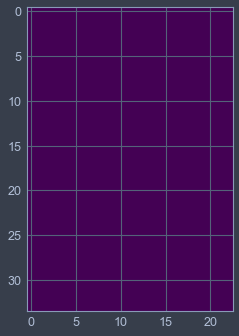

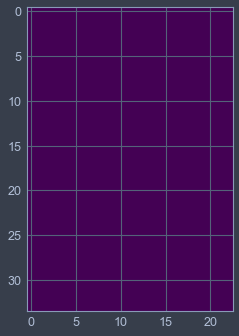

10000
Average: 17.518651865186513


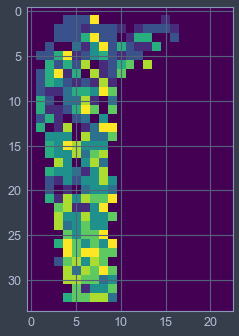

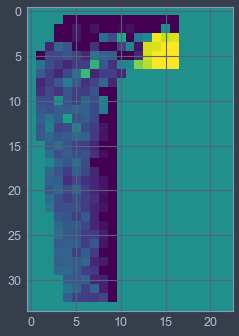

20000
Average: 13.99959995999606


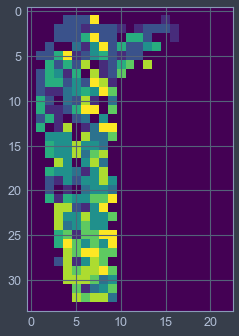

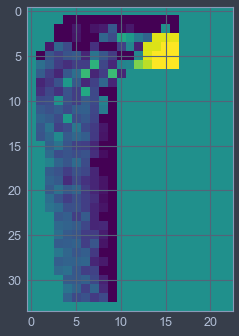

30000
Average: 13.70717071707169


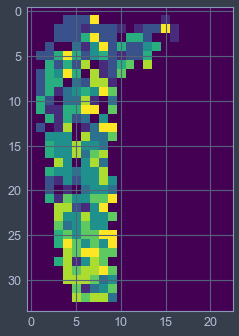

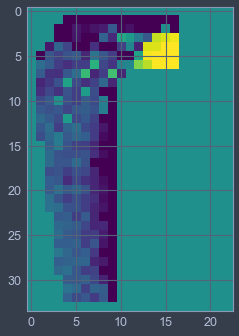

40000
Average: 13.487948794879523


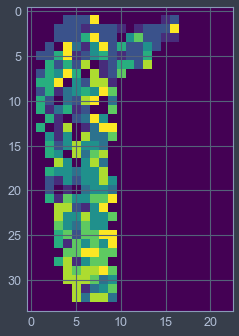

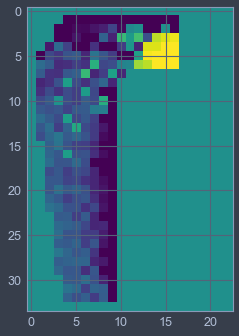

50000
Average: 12.94489448944887


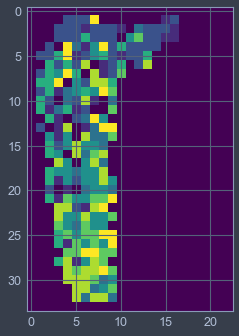

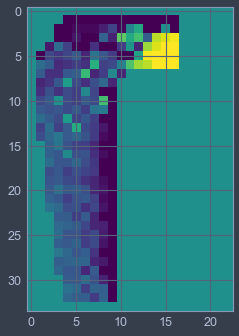

60000
Average: 12.86748674867491


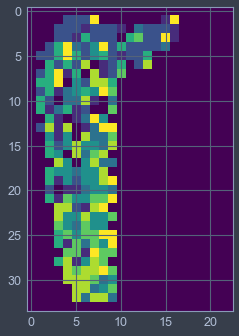

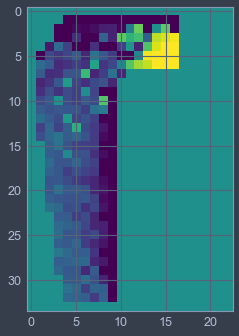

70000
Average: 12.794879487948775


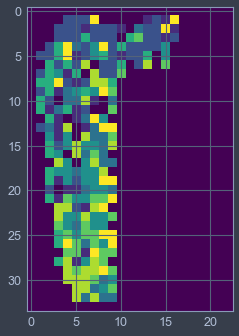

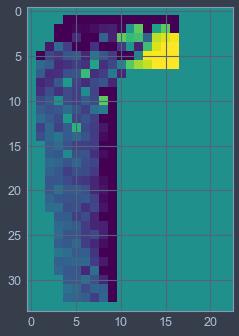

80000
Average: 12.200120012001243


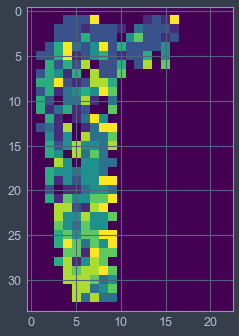

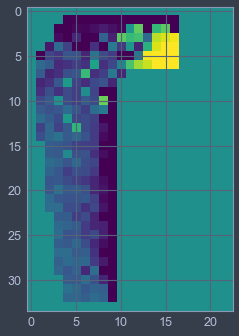

90000
Average: 12.36993699369937


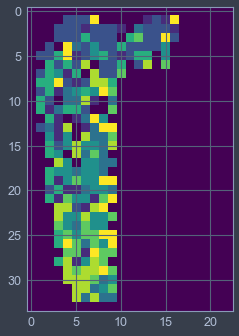

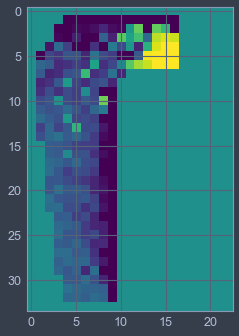

-13.0


<Figure size 460.8x403.2 with 0 Axes>

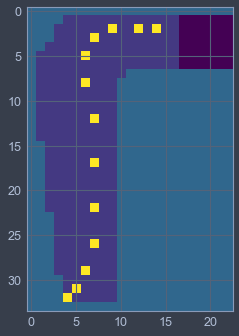

<Figure size 460.8x403.2 with 0 Axes>

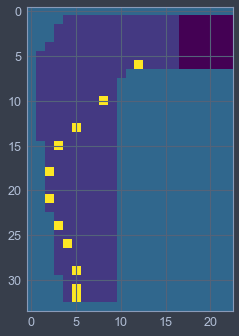

<Figure size 460.8x403.2 with 0 Axes>

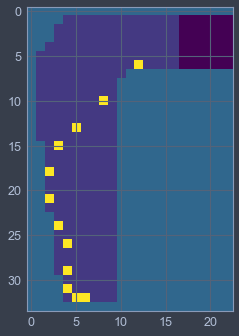

<Figure size 460.8x403.2 with 0 Axes>

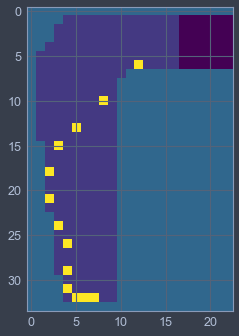

<Figure size 460.8x403.2 with 0 Axes>

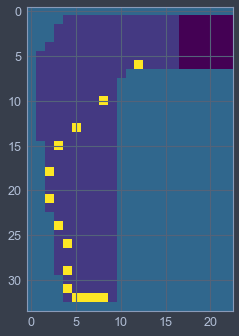

<Figure size 460.8x403.2 with 0 Axes>

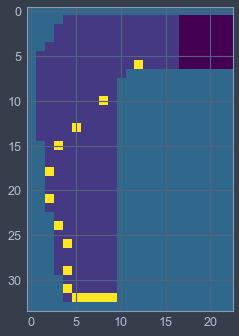

In [826]:
def make_track():
    track = np.zeros((34, 23))
    track[33, :] = 1
    track[:, 0] = 1
    track[0, :] = 1
    track[:5, 1] = 1
    track[:4, 2] = 1
    track[:2, 3] = 1
    track[15:, 1] = 1
    track[23:, 2] = 1
    track[30:, 3] = 1
    track[8:, 10] = 1
    track[7:, 11:] = 1
    track[1:7, 17:] = -1
    start = [(32, 4), (32, 5), (32, 6), (32, 7), (32, 8), (32, 9)]

    return start, track

def map_to_deltav(action_idx):
    return [(-1,1), (1,0), (1,1), (0,-1), (0,0), (0,1), (-1,-1), (-1,0), (1,-1)][action_idx]

def generate_episode(start, track, policy):
    velocity = np.array([0, 0])
    states = []
    rewards = [0] # maintain consistent indexing
    actions = []
    action_probs = []
    position = np.array(list(random.choice(start)))
    #print(position)
    crash_count = 0
    while True:
        states.append(position.copy())
        #print(states)
        action, pr = policy(tuple(position), velocity)
        actions.append(action)
        action_probs.append(pr)
        dv = map_to_deltav(action)
        velocity += dv
        bad_action = False
        if ((velocity[0] == 0 and dv[0] == 1) or (velocity[1] == 0 and dv[1] == -1)):
            bad_action = True
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            velocity[1] = 1
            bad_action = True
        #print(velocity)
        #velocity = [min(max(v, 0), -4) for v in velocity]
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)
        
        if (track[tuple(position)] == 1 or track[tuple(position)] == -1):
            if track[tuple(position)] == 1:
                rewards.append(-12.0)
                if (crash_count < 0):
                    position = np.array(list(random.choice(start)))
                    velocity = np.array([0, 0])
                    crash_count += 1
                    continue
            else:
                rewards.append(12.0)
            return np.array(states, dtype=int), np.array(rewards, dtype=int), np.array(actions, dtype=int), np.array(action_probs, dtype=float)
        if bad_action:
            rewards.append(-3)
        elif position[0] < 20:
            rewards.append(-1)
        else:
            rewards.append(-1)
        
def train(trackinfo):
    N_episodes = 100000
    epsilon = 0.03
    gamma = 0.7
    start, track = trackinfo
    Q = np.zeros(tuple(list(track.shape) + [9]))
    C = np.zeros(tuple(list(track.shape) + [9]))
    pi = np.zeros(tuple(track.shape), dtype=int)
    for i in range(track.shape[0]):
        for j in range(track.shape[1]):
            pi[i, j] = np.argmax(Q[i, j])
            
    def make_soft_policy(pi, epsilon):
        def b(position, velocity):
            rand = random.uniform(0, 1)
            non_greedy = [0,1,2,3,4,5,6,7,8]
            greedy = pi[position]
            '''
            if (velocity[0] == 0):
                non_greedy.remove(1)
                non_greedy.remove(2)
                non_greedy.remove(8)
                if (greedy == 1 or greedy == 2 or greedy == 8):
                    greedy = 4
            if (velocity[1] == 0):
                non_greedy.remove(3)
                non_greedy.remove(6)
                if (velocity[0] != 0):
                    non_greedy.remove(8)
                if (greedy == 3 or greedy == 6 or greedy == 8):
                    greedy = 4'''

            if (rand < epsilon):
                return random.choice(non_greedy), epsilon / len(non_greedy)
            else:
                return greedy, 1 - epsilon + epsilon / len(non_greedy)
        return b
    
    T_avg = 0
    for n in range(N_episodes):
        b = make_soft_policy(pi, epsilon)
        states, rewards, actions, action_prob = generate_episode(start, track, b)
        #print(np.transpose(states))
        #print(actions)
        #print(rewards)
        T = len(states)
        G = 0.0
        W = 1.0
        SA = [tuple(np.append(state, action)) for state, action in zip(states, actions)]
        #if (T > 5):
            #print(rewards)
        if (n % 10000 == 0):
            print(n)
            if (n == 0):
                print(T)
            else:
                print('Average: {}'.format(T_avg))
                #bp = make_soft_policy(pi, 0.0)
                #statesp, rewardsp, actionsp, action_probp = generate_episode(start, track, bp)
                #print('Greedy: {}'.format(len(statesp)))
            T_avg = T
            plt.imshow(pi)
            plt.show()
            plt.imshow(Q[:,:,0])
            plt.show()
        else:
            T_avg = T_avg + 1/(n % 10000) * (T - T_avg)
        for t in range(0, T):
            t = T-t-1
            SAt = SA[t]
            #if (T > 5):
                #print('G before: {}'.format(G))
            G = gamma * G + rewards[t + 1]
            #if (T > 5):
                #print('G after: {}'.format(G))
            C[SAt] = C[SAt] + W

            '''if (C[SAt] == 0.0):
                print('Q og: {}'.format(Q[SAt]))
                print('rewards: {}'.format(rewards))
                print('Q: {}'.format(Q[SAt] + W * (G - Q[SAt]) / C[SAt]))
                print('W: {}'.format(W))
                print('G: {}'.format(G))
                print('G - Q: {}'.format(G - Q[SAt]))
                print('C: {}'.format(C[SAt]))'''
            Q[SAt] = Q[SAt] + W * (G - Q[SAt]) / C[SAt]
            pi[SAt[:2]] = np.argmax(Q[SAt[:2]])
            #if (T > 5):
                #print(SAt[-1])
                #print(pi[SAt[:2]])
            if SAt[-1] != pi[SAt[:2]]:
                #print(pi[SAt[:2]])
                break
            else:
                W = W / action_prob[t]
                #print("update")
        #print(Q_old - Q)

    return pi, Q

def validate_policy(track, policy, start):
    states = []
    actions = []
    rewards = []
    position = start
    velocity = np.array([0,0])
    while True:
        states.append(position.copy())
        action = policy[tuple(position)]
        actions.append(action)
        velocity += map_to_deltav(action)
        velocity[0] = min(max(velocity[0], -5), 1)
        velocity[1] = min(max(velocity[1], -1), 5)
        if (velocity[0] == 0 and velocity[1] == 0):
            print('control')
            velocity[1] = 1
        position += velocity
        position[0] = min(max(position[0], 0), 33)
        position[1] = min(max(position[1], 0), 22)
        if (track[tuple(position)] == 1 or track[tuple(position)] == -1):
            if track[tuple(position)] == 1:
                rewards.append(-10.0)
                print('fail')
                return np.array(states, dtype=int), np.sum(np.array(rewards, dtype=int)), np.array(actions, dtype=int)
            else:
                rewards.append(-1.0)
                return np.array(states, dtype=int), np.sum(np.array(rewards, dtype=int)), np.array(actions, dtype=int)
        else:
            rewards.append(-1.0)
            
if __name__ == '__main__':
    start, track = make_track()
    pi, Q = train((start, track))
    starts, track = make_track()
    rewards = 0
    for s in start:
        s = np.array(list(s))
        states, reward, actions = validate_policy(track, pi, s)
        rewards += reward
        plt.figure()
        track_trace = track.copy()
        for s in states:
            track_trace[tuple(s)] = 5

        plt.figure()
        plt.imshow(track_trace)
    print(rewards/len(start))
    